In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn import metrics

from sklearn import model_selection

from sklearn.ensemble import RandomForestClassifier

In [10]:
df_train = pd.read_csv('train.csv')
df_train.head()

df_test = pd.read_csv('test-1.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,av15.1,av16.1,av17.1,av18.1,av19.1,av20.1,av21.1,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


In [11]:
df_test.columns

Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3',
       'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12',
       'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21',
       'av1.1', 'av2.1', 'av3.1', 'av4.1', 'av5.1', 'av6.1', 'av7.1', 'av8.1',
       'av9.1', 'av10.1', 'av11.1', 'av12.1', 'av13.1', 'av14.1', 'av15.1',
       'av16.1', 'av17.1', 'av18.1', 'av19.1', 'av20.1', 'av21.1', 'ttf',
       'label_bnc', 'label_mcc'],
      dtype='object')

In [12]:
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
features_extr = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21','av1','av2','av3','av4','av5','av6','av7','av8','av9','av10','av11','av12','av13','av14','av15','av16','av17','av18','av19','av20','av21']
y_train = df_train['label_bnc']
y_test = df_test['label_bnc']

In [13]:
def bin_classify(model,clf,features,params=None,score=None):
    X_train = df_train[features]
    X_test = df_test[features]
    grid_search = model_selection.GridSearchCV(estimator=clf,param_grid=params,cv=5,scoring=score,n_jobs=-1)
    
    grid_search.fit(X_train,y_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search,'predict_proba'):
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search,'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    predictions = {'y_pred' : y_pred,'y_score':y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_,df_predictions

In [14]:
def bin_class_metrics(model,y_test,y_pred,y_score,print_out=True,plot_out=True):
    binclass_matrics = {
                        'Accuracy' : metrics.accuracy_score(y_test,y_pred),
                        'Precision': metrics.precision_score(y_test,y_pred),
                        'Recall' : metrics.recall_score(y_test,y_pred),
                        'F1 score' : metrics.f1_score(y_test,y_pred),
                        'ROC AUC' : metrics.roc_auc_score(y_test,y_pred)
    }
    
    df_metrics = pd.DataFrame.from_dict(binclass_matrics,orient='index')
    df_metrics.columns = [model]
    
    fpr,tpr,thresh_roc = metrics.roc_curve(y_test,y_score)
    
    roc_auc = metrics.auc(fpr,tpr)
    
    engines_roc = []
    for thr in thresh_roc:
        engines_roc.append((y_score >= thr).mean())
        
    engines_roc = np.array(engines_roc)
    
    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'Que' : engines_roc
                    }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    
    df_roc_thresh['TP'] = (25*df_roc_thresh.TPR).astype(int)
    df_roc_thresh['FP'] = (25 - (25*df_roc_thresh.TPR)).astype(int)
    df_roc_thresh['TN'] = (75*(1-df_roc_thresh.FPR)).astype(int)
    df_roc_thresh['FN'] = (75 - (75*(1-df_roc_thresh.FPR))).astype(int)
    
    df_roc_thresh['TNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN']+df_roc_thresh['FN'])
    df_roc_thresh['FNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN']+df_roc_thresh['FP'])
    
    df_roc_thresh['Model'] = model
    
    precision,recall,thresh_prc = metrics.precision_recall_curve(y_test,y_score)
    
    thresh_prc = np.append(thresh_prc,1)
    
    engines_prc = []
    for thr in thresh_prc:
        engines_prc.append((y_score>=thr).mean())
    
    engines_prc = np.array(engines_prc)
    
    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Que' : engines_prc
    }
    
    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)
    
    if print_out:
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test,y_pred))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test,y_pred))
        print('\nMetrics')
        print(df_metrics)
        
        print('\nROC Thresholds:\n')
        print(df_roc_thresh[['Threshold','TP','FP','TN','FN','TPR','FPR','TNR','FNR','Que']])
        
        print('\nPrecision-Recall Threshold:\n')
        print(df_prc_thresh[['Threshold','Precision','Recall','Que']])
        
    if plot_out:
        fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=False)
        fig.set_size_inches(10,10)
        
        ax1.plot(fpr,tpr,color='darkorange',lw=2,label='AUC=%0.2f'%roc_auc)
        ax1.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
        ax1.set_xlim([-0.05,1.0])
        ax1.set_ylim([0.0,1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right",fontsize='small')
        
        ax2.plot(recall,precision,color='blue',lw=2,label='Precision-Recall curve')
        ax2.set_xlim([0.0,1.0])
        ax2.set_ylim([0.0,1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower right",fontsize='small')
        
        ax3.plot(thresh_roc,fpr,color='red',lw=2,label='FPR')
        ax3.plot(thresh_roc,tpr,color='green',label='TPR')
        ax3.plot(thresh_roc,engines_roc,color='blue',label='Engines') 
        ax3.set_ylim([0.0,1.05])
        ax3.set_xlabel('Threshold')
        ax3.set_ylabel('%')
        ax3.legend(loc="upper right",fontsize='small')
        
        ax4.plot(thresh_prc,precision,color='red',lw=2,label='Precision')
        ax4.plot(thresh_prc,recall,color='green',label='Recall')
        ax4.plot(thresh_prc,engines_prc,color='blue',label='Engines') 
        ax4.set_ylim([0.0,1.05])
        ax4.set_xlabel('Threshold')
        ax4.set_ylabel('%')
        ax4.legend(loc="lower right",fontsize='small')
    return df_metrics,df_roc_thresh,df_prc_thresh


Best Performance:
 RandomForestClassifier(n_estimators=50, random_state=123)
Random Forest B 

Confusion Matrix:
[[17374   157]
 [  390  2710]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     17531
           1       0.95      0.87      0.91      3100

    accuracy                           0.97     20631
   macro avg       0.96      0.93      0.95     20631
weighted avg       0.97      0.97      0.97     20631


Metrics
           Random Forest B
Accuracy          0.973487
Precision         0.945239
Recall            0.874194
F1 score          0.908329
ROC AUC           0.932619

ROC Thresholds:

      Threshold  TP  FP  TN  FN       TPR       FPR       TNR       FNR  \
0      2.000000   0  25  75   0  0.000000  0.000000  1.000000  0.750000   
1      1.000000   0  24  75   0  0.011935  0.000000  1.000000  0.757576   
2      0.999933   0  24  75   0  0.017419  0.000000  1.000000  0.757576   
3      0.999869

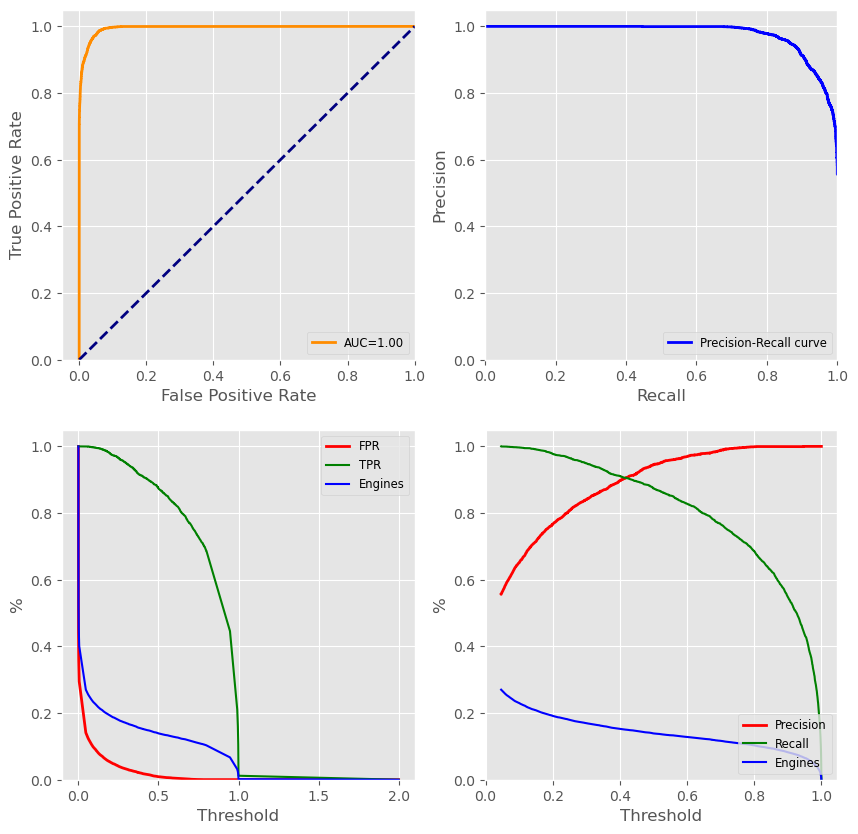

In [15]:
model = 'Random Forest B'
clf_rfcb = RandomForestClassifier(n_estimators=50,random_state=123)
gs_params = {'max_depth' : [4,5,6,7,8],'criterion':['gini','entropy']}
gs_score = 'roc_auc'

clr_rfcb,pred_rfcb = bin_classify(model,clf_rfcb,features_orig,params=gs_params,score=gs_score)
print('\nBest Performance:\n',clf_rfcb)

metrics_rfcb,roc_rfcb,prc_rfcb = bin_class_metrics(model,y_test,pred_rfcb.y_pred,pred_rfcb.y_score,print_out=True,plot_out=True)


Best Performance:
 RandomForestClassifier(n_estimators=50, random_state=123)
Random Forest A 

Confusion Matrix:
[[17359   172]
 [  412  2688]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     17531
           1       0.94      0.87      0.90      3100

    accuracy                           0.97     20631
   macro avg       0.96      0.93      0.94     20631
weighted avg       0.97      0.97      0.97     20631


Metrics
           Random Forest A
Accuracy          0.971693
Precision         0.939860
Recall            0.867097
F1 score          0.902013
ROC AUC           0.928643

ROC Thresholds:

      Threshold  TP  FP  TN  FN       TPR       FPR       TNR       FNR  \
0      2.000000   0  25  75   0  0.000000  0.000000  1.000000  0.750000   
1      1.000000   5  19  75   0  0.214194  0.000000  1.000000  0.797872   
2      0.999840   5  19  75   0  0.214516  0.000000  1.000000  0.797872   
3      0.999831

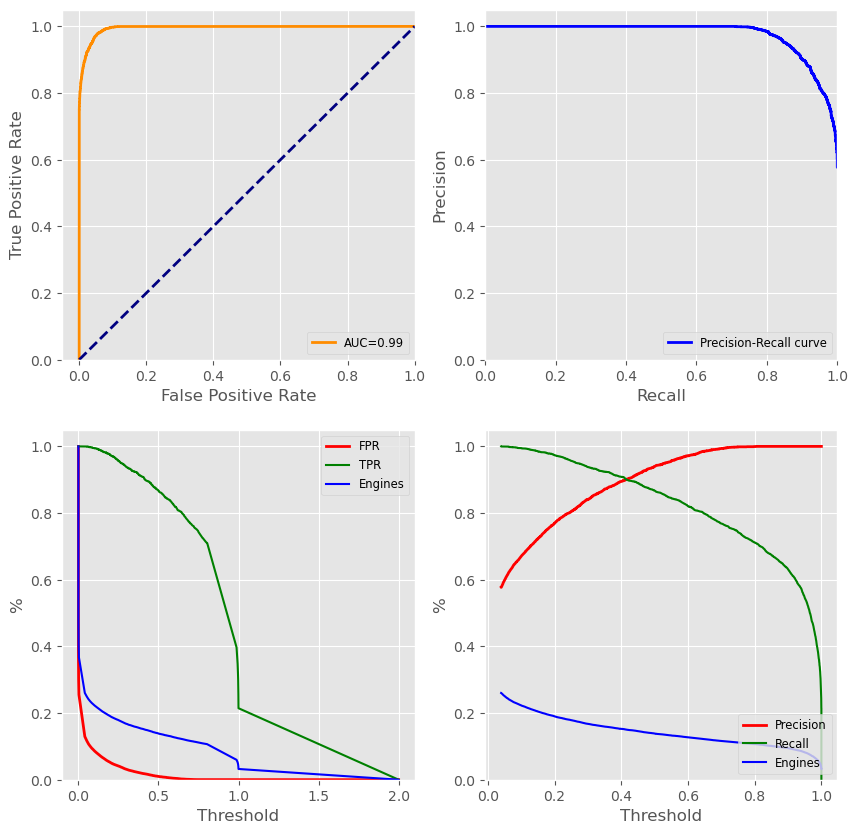

In [16]:
model = 'Random Forest A'
clf_rfca = RandomForestClassifier(n_estimators=50,random_state=123)
gs_params = {'max_depth' : [4,5,6,7,8],'criterion':['gini','entropy']}
gs_score = 'roc_auc'

clr_rfca,pred_rfca = bin_classify(model,clf_rfca,features_extr,params=gs_params,score=gs_score)
print('\nBest Performance:\n',clf_rfca)

metrics_rfca,roc_rfca,prc_rfca = bin_class_metrics(model,y_test,pred_rfca.y_pred,pred_rfca.y_score,print_out=True,plot_out=True)

In [17]:
metrics_rfc = pd.concat([metrics_rfcb,metrics_rfca],axis=1)
metrics_rfc

,Random Forest B,Random Forest A
Accuracy,0.973487,0.971693
Precision,0.945239,0.939860
Recall,0.874194,0.867097
F1 score,0.908329,0.902013
ROC AUC,0.932619,0.928643
